In [2]:
import mediapipe as mp
import cv2
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [48]:
class KeypointDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.X = self.data.drop(columns=['label']).values.astype(np.float32)
        self.y = self.data['label'].values.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx])
        y = torch.tensor(self.y[idx])
        return X, y

In [49]:
dataset = KeypointDataset('keypoints_dataset.csv')

In [5]:
print(type(dataset[10]))
print(len(dataset))

<class 'tuple'>
145


In [50]:
img, label = dataset[10]
print(type(img), type(label))
print(img.shape)
print(img.dtype)
print(img.max(), img.min())
print(label)
print(img.squeeze().shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([99])
torch.float32
tensor(1.1827) tensor(-0.4215)
tensor(0)
torch.Size([99])


In [72]:
# 하이퍼파라미퍼 튜님

batch_size = 32
learning_rate = 0.0001
num_epochs = 2000
dropout_n = 0.5

In [73]:
class KeypointClassifier(nn.Module):
    def __init__(self, input_size=99, hidden_size=128, num_classes=2):
        super(KeypointClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [74]:
# Load dataset

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [75]:
model = KeypointClassifier()
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        # scheduler.step()
        logits = model(images)
        loss = ce(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

epoch 1/2000, Loss: 2.7986
epoch 2/2000, Loss: 2.7845
epoch 3/2000, Loss: 2.7919
epoch 4/2000, Loss: 2.8099
epoch 5/2000, Loss: 2.7792
epoch 6/2000, Loss: 2.7924
epoch 7/2000, Loss: 2.8052
epoch 8/2000, Loss: 2.7797
epoch 9/2000, Loss: 2.7404
epoch 10/2000, Loss: 2.8094
epoch 11/2000, Loss: 2.7514
epoch 12/2000, Loss: 2.7811
epoch 13/2000, Loss: 2.7679
epoch 14/2000, Loss: 2.7568
epoch 15/2000, Loss: 2.7860
epoch 16/2000, Loss: 2.7886
epoch 17/2000, Loss: 2.7704
epoch 18/2000, Loss: 2.7805
epoch 19/2000, Loss: 2.7539
epoch 20/2000, Loss: 2.7785
epoch 21/2000, Loss: 2.7821
epoch 22/2000, Loss: 2.7879
epoch 23/2000, Loss: 2.7739
epoch 24/2000, Loss: 2.7664
epoch 25/2000, Loss: 2.7598
epoch 26/2000, Loss: 2.7496
epoch 27/2000, Loss: 2.8072
epoch 28/2000, Loss: 2.7387
epoch 29/2000, Loss: 2.7570
epoch 30/2000, Loss: 2.7681
epoch 31/2000, Loss: 2.8069
epoch 32/2000, Loss: 2.7640
epoch 33/2000, Loss: 2.7611
epoch 34/2000, Loss: 2.7812
epoch 35/2000, Loss: 2.7680
epoch 36/2000, Loss: 2.7782
e

In [76]:
@torch.no_grad()
def validate(f, dataloader):
    num_correct = 0
    num_total = 0
    for images, labels in dataloader:
        # images = images.to(device)
        # labels = labels.to(device)
        logits = f(images)
        prediction = logits.argmax(dim=1)
        num_correct += (prediction == labels).type(torch.float).sum().item()
        num_total += len(labels)
    return num_correct / num_total

Epoch 1/2000, Loss: 2.8321
Epoch 2/2000, Loss: 2.8402
Epoch 3/2000, Loss: 2.8112
Epoch 4/2000, Loss: 2.8060
Epoch 5/2000, Loss: 2.8264
Epoch 6/2000, Loss: 2.8133
Epoch 7/2000, Loss: 2.8061
Epoch 8/2000, Loss: 2.7505
Epoch 9/2000, Loss: 2.7480
Epoch 10/2000, Loss: 2.8015
Epoch 11/2000, Loss: 2.8169
Epoch 12/2000, Loss: 2.7557
Epoch 13/2000, Loss: 2.7808
Epoch 14/2000, Loss: 2.7321
Epoch 15/2000, Loss: 2.7745
Epoch 16/2000, Loss: 2.7723
Epoch 17/2000, Loss: 2.7681
Epoch 18/2000, Loss: 2.7664
Epoch 19/2000, Loss: 2.8332
Epoch 20/2000, Loss: 2.7990
Epoch 21/2000, Loss: 2.7537
Epoch 22/2000, Loss: 2.8234
Epoch 23/2000, Loss: 2.7376
Epoch 24/2000, Loss: 2.7405
Epoch 25/2000, Loss: 2.8031
Epoch 26/2000, Loss: 2.7275
Epoch 27/2000, Loss: 2.7840
Epoch 28/2000, Loss: 2.7756
Epoch 29/2000, Loss: 2.7951
Epoch 30/2000, Loss: 2.7908
Epoch 31/2000, Loss: 2.6659
Epoch 32/2000, Loss: 2.7848
Epoch 33/2000, Loss: 2.7393
Epoch 34/2000, Loss: 2.7220
Epoch 35/2000, Loss: 2.7699
Epoch 36/2000, Loss: 2.7610
E

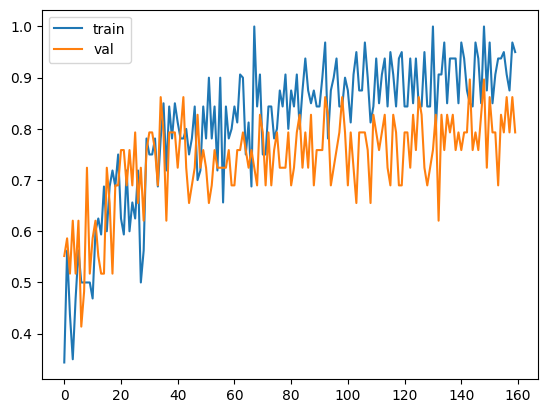

In [77]:
model = KeypointClassifier()
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

accuracies_train = []
accuracies_val = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        logits = model(images)
        loss = ce(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 50 epoch 마다 계산
        if epoch % 50 == 0:
            prediction = logits.argmax(dim=1)
            num_correct = (prediction == labels).type(torch.float).sum().item()
            accuracy_train = num_correct / len(labels)
            accuracies_train.append(accuracy_train)
            accuracy_val = validate(model, dataloader_val)
            accuracies_val.append(accuracy_val)
    
    # Print loss at the end of each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Plot training and validation accuracies
plt.plot(accuracies_train, label="train")
plt.plot(accuracies_val, label="val")
plt.legend()
plt.show()

In [78]:
print(accuracies_train)
print(accuracies_val)

[0.34375, 0.5625, 0.4375, 0.35, 0.46875, 0.5625, 0.5, 0.5, 0.5, 0.5, 0.46875, 0.6, 0.625, 0.59375, 0.6875, 0.6, 0.6875, 0.71875, 0.6875, 0.75, 0.625, 0.59375, 0.71875, 0.6, 0.65625, 0.625, 0.71875, 0.5, 0.5625, 0.78125, 0.75, 0.75, 0.78125, 0.6875, 0.78125, 0.85, 0.71875, 0.84375, 0.78125, 0.85, 0.8125, 0.78125, 0.78125, 0.8, 0.75, 0.78125, 0.84375, 0.7, 0.71875, 0.84375, 0.78125, 0.9, 0.78125, 0.84375, 0.71875, 0.9, 0.65625, 0.84375, 0.78125, 0.8, 0.84375, 0.8125, 0.90625, 0.9, 0.75, 0.8125, 0.6875, 1.0, 0.84375, 0.90625, 0.75, 0.75, 0.84375, 0.84375, 0.78125, 0.8, 0.875, 0.84375, 0.90625, 0.8, 0.875, 0.84375, 0.90625, 0.8, 0.875, 0.9375, 0.875, 0.85, 0.875, 0.84375, 0.84375, 0.9, 0.96875, 0.78125, 0.875, 0.9, 0.9375, 0.84375, 0.84375, 0.9, 0.875, 0.8125, 0.90625, 0.95, 0.875, 0.875, 0.96875, 0.9, 0.8125, 0.84375, 0.9375, 0.85, 0.90625, 0.9375, 0.84375, 0.95, 0.90625, 0.84375, 0.9375, 0.95, 0.84375, 0.84375, 0.9375, 0.85, 0.9375, 0.84375, 0.84375, 0.95, 0.84375, 0.84375, 1.0, 0.8, 0.9

In [79]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in dataloader_val:
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


I0000 00:00:1733986804.164169 1443927 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2 Pro
W0000 00:00:1733986804.252672 1486414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733986804.265268 1486423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Incorrect



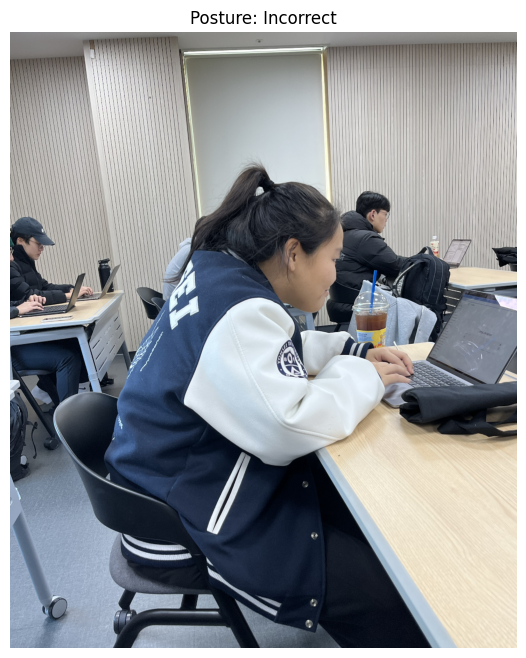

In [83]:
from PIL import Image

mp_pose = mp.solutions.pose

def extract_keypoints(image_path):
    # Initialize MediaPipe pose detection
    with mp_pose.Pose(static_image_mode=True) as pose:
        # Read and preprocess image
        image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image to detect keypoints
        results = pose.process(rgb_image)

        # Extract keypoints
        if results.pose_landmarks:
            keypoints = [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
            return np.array(keypoints).flatten()  # Flatten to a single array
        else:
            return np.zeros(99)  # Return zeros if no keypoints detected

# Load a new image
new_image_path = 'incorrect_mimi.png'
keypoints = extract_keypoints(new_image_path)
keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0)

# Predict posture
model.eval()
with torch.no_grad():
    output = model(keypoints_tensor)
    _, predicted = torch.max(output, 1)
    posture = "Correct" if predicted[0] == 1 else "Incorrect"
    print(posture)
    print()

image = Image.open(new_image_path)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f"Posture: {posture}")
plt.axis('off')
plt.show()